<a href="https://colab.research.google.com/github/Aryanupadhyay23/Deep-Learning-/blob/main/UNET_Butterfly_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import os
import shutil
import numpy as np
import re
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import kagglehub

In [47]:
path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset")

Using Colab cache for faster access to the 'butterfly-dataset' dataset.


In [48]:
print(path)

/kaggle/input/butterfly-dataset


In [49]:
# Download dataset
path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset")

print("Downloaded to:", path)

# Move to /content
destination = "/content/butterfly-dataset"

if not os.path.exists(destination):
    shutil.copytree(path, destination)

print("Now available at:", destination)


Using Colab cache for faster access to the 'butterfly-dataset' dataset.
Downloaded to: /kaggle/input/butterfly-dataset
Now available at: /content/butterfly-dataset


In [50]:
image_path = '/content/butterfly-dataset/leedsbutterfly/images'
mask_path = '/content/butterfly-dataset/leedsbutterfly/segmentations'

In [51]:
images = os.listdir(image_path)
masks = os.listdir(mask_path)

print(f'Number of images: {len(images)}')
print(f'Number of masks: {len(masks)}')

Number of images: 832
Number of masks: 832


In [52]:
def get_corresponding_mask(image_name):
    base_name = image_name.split('.')[0]
    mask_name = f"{base_name}_seg0.png"
    return mask_name

In [53]:
def show_samples(image_list, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path, image_list[i]))
        mask_name = get_corresponding_mask(image_list[i])
        mask = Image.open(os.path.join(mask_path, mask_name))

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis('off')

    plt.show()

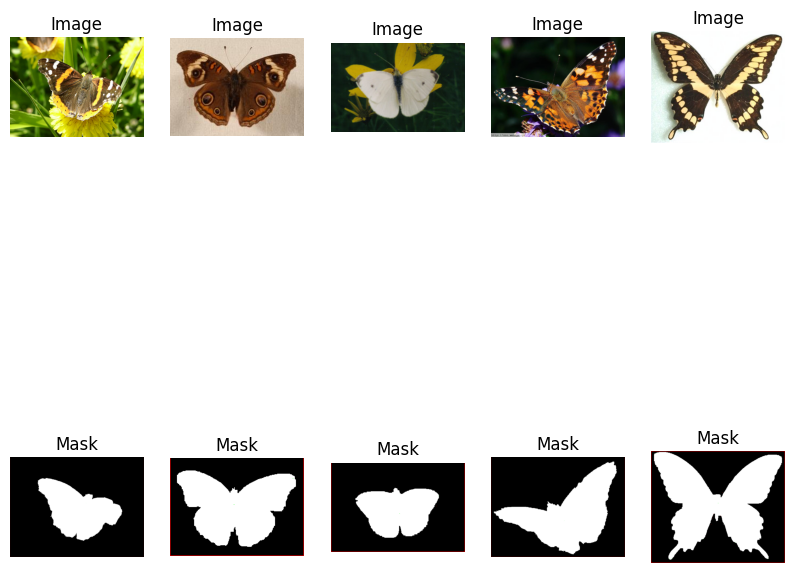

In [54]:
show_samples(images, num_samples=5)

In [55]:
# Function to load and preprocess the dataset
def load_data(image_dir, mask_dir, image_shape=256):
    """
    Loads and preprocesses images and masks for training.

    Args:
        image_dir (str): Directory containing the images.
        mask_dir (str): Directory containing the masks.
        image_shape (int, optional): Shape to resize the images and masks. Defaults to 256.

    Returns:
        tuple: Arrays of preprocessed images and masks.
    """

    image_list = []
    mask_list = []

    image_names = os.listdir(image_dir)
    mask_names = [re.sub(r'\.png', '_seg0.png', name) for name in image_names]

    for img_name, mask_name in zip(image_names, mask_names):
        try:
            img = plt.imread(os.path.join(image_dir, img_name))
            mask = plt.imread(os.path.join(mask_dir, mask_name))
        except FileNotFoundError:
            print("file not found")
            continue

        # Resizing the images and masks
        img_resized = cv2.resize(img, (image_shape, image_shape))
        mask_resized = cv2.resize(mask, (image_shape, image_shape))

        # Storing the preprocessed data
        image_list.append(img_resized)
        mask_list.append(mask_resized[:, :, 0])  # Use the first channel for binary masks

    return np.array(image_list), np.array(mask_list)


In [56]:
# Load data
image_dir = '/content/butterfly-dataset/leedsbutterfly/images'
mask_dir = '/content/butterfly-dataset/leedsbutterfly/segmentations'

images, masks = load_data(image_dir, mask_dir)

In [57]:
images.shape, masks.shape

((832, 256, 256, 3), (832, 256, 256))

In [58]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [59]:
# Function to create a convolutional block for the U-Net model
def convolutional_block(input_tensor, num_filters, kernel_size=3, use_batch_norm=True):
    """
    Performs two convolution operations with optional batch normalization.

    Args:
        input_tensor (tensor): Input to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int, optional): Size of the convolution kernel. Defaults to 3.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        tensor: Output after applying convolution, batch normalization, and activation.
    """

    # First convolution
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal',
        padding='same'
    )(input_tensor)

    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    # Second convolution
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal',
        padding='same'
    )(x)

    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x

In [60]:
# Function to create a U-Net model
def build_unet(input_shape, num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    """
    Builds a U-Net model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_filters (int, optional): Number of filters for the initial layer. Defaults to 16.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.1.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        keras.Model: Compiled U-Net model.
    """

    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    c1 = convolutional_block(inputs, num_filters * 1, use_batch_norm=use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolutional_block(p1, num_filters * 2, use_batch_norm=use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolutional_block(p2, num_filters * 4, use_batch_norm=use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolutional_block(p3, num_filters * 8, use_batch_norm=use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = convolutional_block(p4, num_filters * 16, use_batch_norm=use_batch_norm)

    # Decoder path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3),
                                         strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolutional_block(u6, num_filters * 8, use_batch_norm=use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3),
                                         strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolutional_block(u7, num_filters * 4, use_batch_norm=use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3),
                                         strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolutional_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3),
                                         strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolutional_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)

    # Output layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model creation
    model = tf.keras.Model(inputs=[inputs], outputs=[output])

    return model

In [61]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_18[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_20[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_5[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [63]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    'unet_model_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [64]:
# Train the model
history = unet_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6989 - loss: 0.5767   
Epoch 1: val_loss improved from inf to 9.70952, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7024 - loss: 0.5728 - val_accuracy: 0.2747 - val_loss: 9.7095 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8806 - loss: 0.3243
Epoch 2: val_loss improved from 9.70952 to 9.12116, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.8811 - loss: 0.3233 - val_accuracy: 0.3336 - val_loss: 9.1212 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8973 - loss: 0.2683
Epoch 3: val_loss improved from 9.12116 to 4.85808, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.8975 - loss: 0.2678 - val_accuracy: 0.5695 - val_loss: 4.8581 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - a

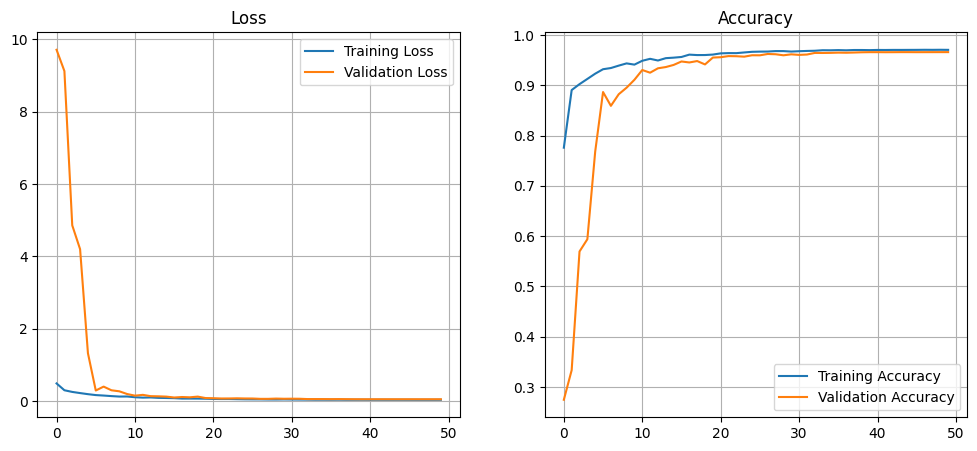

In [65]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

In [66]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    """
    Predicts the segmentation mask for a single image and times the prediction.

    Args:
        image (array): Input image for prediction.
        model (keras.Model): Trained U-Net model.

    Returns:
        tuple: Predicted mask and inference time.
    """

    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()

    inference_time = end_time - start_time

    return prediction, inference_time

In [67]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, and ground truth mask.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Inference time for a single image: 1.5318 seconds


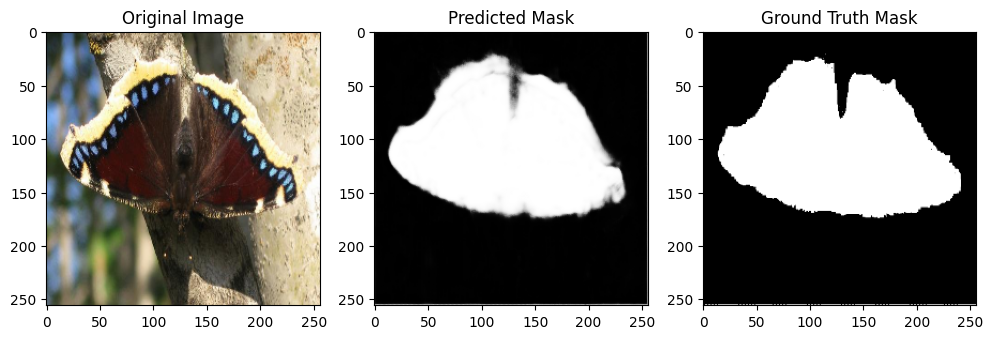

In [68]:
# Example inference on a validation image
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Inference time for a single image: 0.1000 seconds


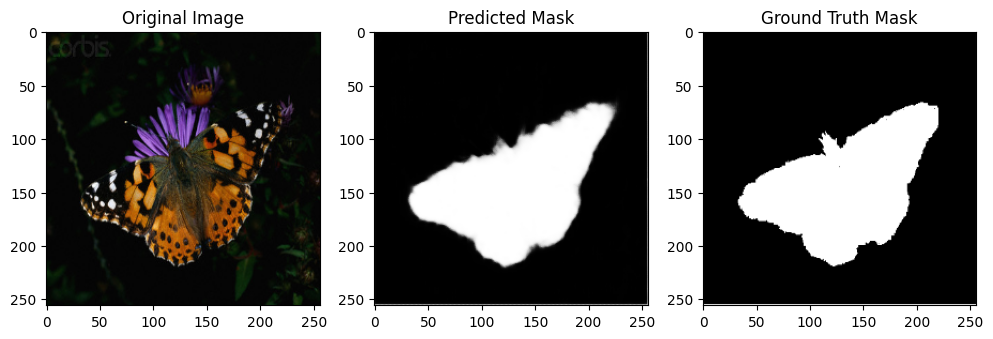

In [69]:
# Example inference on a validation image
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

In [70]:
import tensorflow.keras.backend as K

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

In [71]:
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step
tf.Tensor(0.8881367, shape=(), dtype=float32)


In [72]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Dice coefficient score.
    """

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )


def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

In [73]:
input_shape = (256,256,3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [74]:
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy",mean_iou, dice_coefficient])

In [75]:
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5153 - dice_coefficient: 0.4067 - loss: 0.7278 - mean_iou: 0.2557 - val_accuracy: 0.2848 - val_dice_coefficient: 0.4090 - val_loss: 10.9224 - val_mean_iou: 0.2574
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.8460 - dice_coefficient: 0.5201 - loss: 0.4522 - mean_iou: 0.3523 - val_accuracy: 0.7145 - val_dice_coefficient: 0.4791 - val_loss: 1.7615 - val_mean_iou: 0.3156
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.8875 - dice_coefficient: 0.5994 - loss: 0.3541 - mean_iou: 0.4281 - val_accuracy: 0.5274 - val_dice_coefficient: 0.4718 - val_loss: 5.4267 - val_mean_iou: 0.3093
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.8987 - dice_coefficient: 0.6324 - loss: 0.3077 - mean_iou: 0.4627 - val_accuracy: 0.7297 - val_dice_coefficient: 0.5712 - val_loss: 1.4742 - val_mean_iou: 0.4008
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.9040 - dice_coefficient

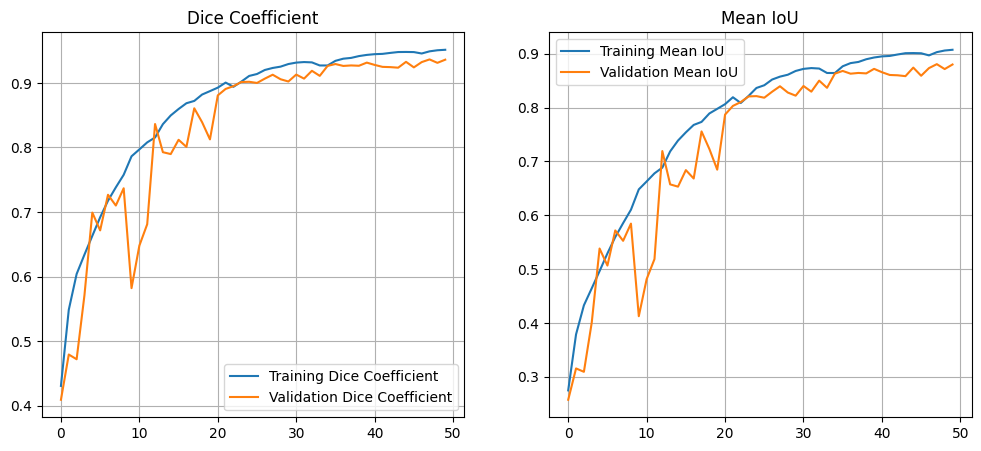

In [76]:
# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.grid()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.legend()
plt.grid()
plt.title('Mean IoU')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


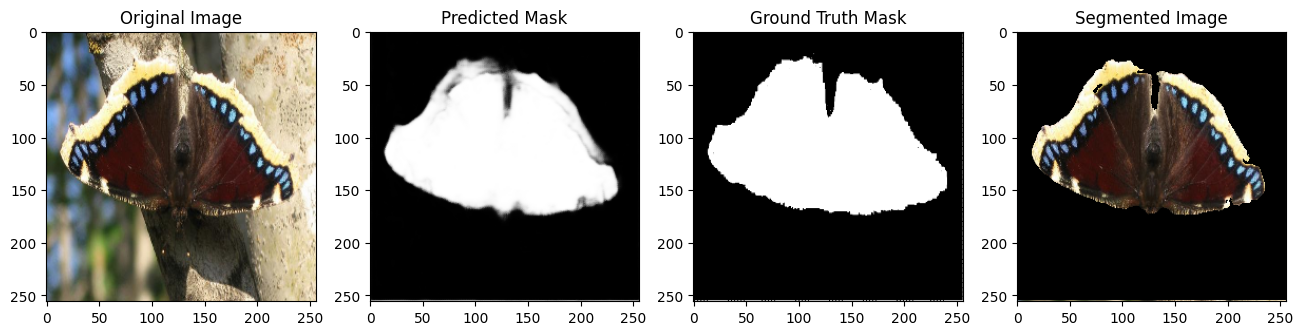

In [80]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, ground truth mask, and segmented image.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """

    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(
    sample_image,
    predicted_mask,
    sample_ground_truth
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


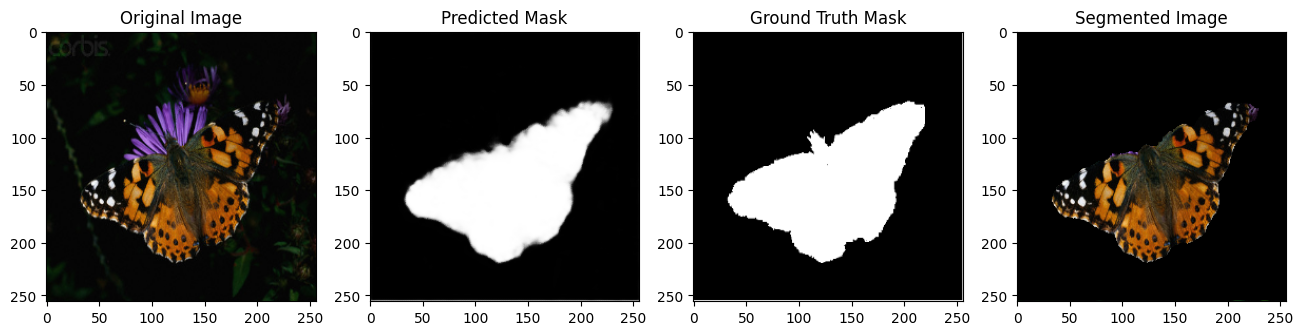

In [81]:
# Example usage
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(
    sample_image,
    predicted_mask,
    sample_ground_truth
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


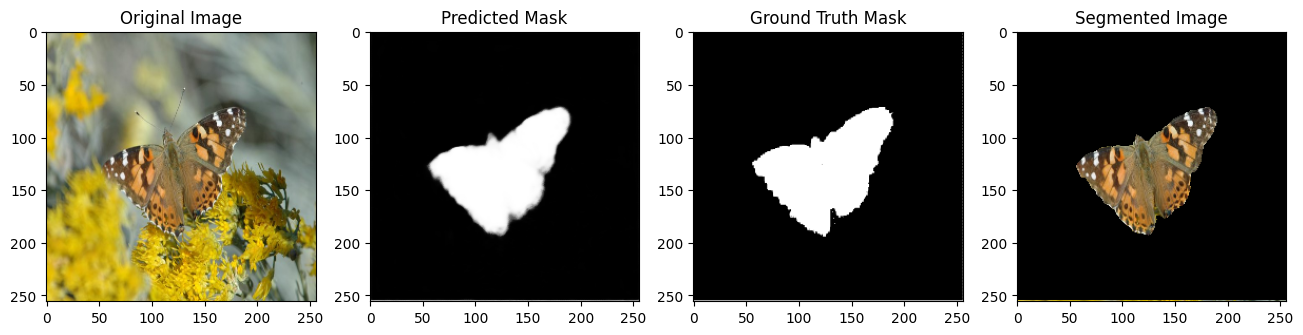

In [82]:
# Example usage
sample_image = X_val[33]
sample_ground_truth = y_val[33]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(
    sample_image,
    predicted_mask,
    sample_ground_truth
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


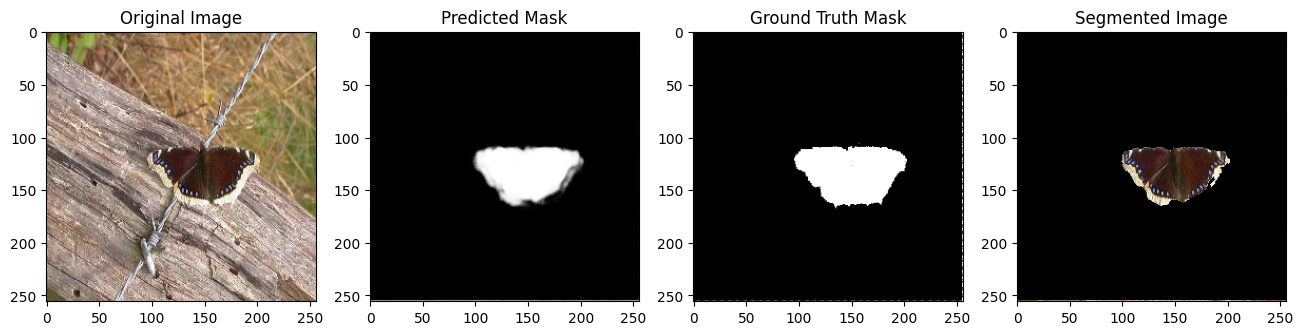

In [83]:
# Example usage
sample_image = X_val[99]
sample_ground_truth = y_val[99]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(
    sample_image,
    predicted_mask,
    sample_ground_truth
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


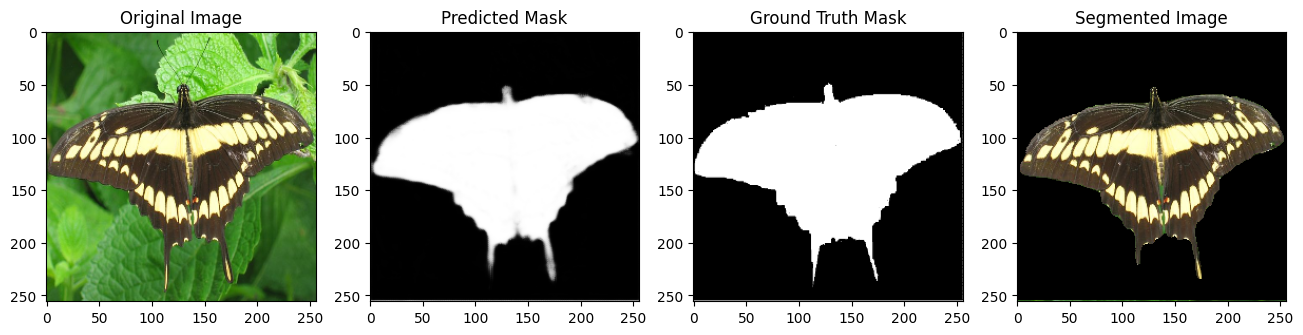

In [86]:
# Example usage
sample_image = X_val[40]
sample_ground_truth = y_val[40]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(
    sample_image,
    predicted_mask,
    sample_ground_truth
)

In [88]:
unet_model.save('final_UNET_Butterfly_segmentation.keras')